# AI - CNN through TensorFlow

# Import

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

Un CNN est une combinaison de deux composants : un module d'extraction de caractéristiques suivi d'un classificateur entraînable. Le premier composant comprend une pile de couches de convolution, d'activation et de pooling. Un DNN se charge de la classification. Chaque neurone d'une couche est connecté à ceux de la couche suivante.

En mathématiques, une convolution est une fonction qui est appliquée sur la sortie d'une autre fonction. Dans notre cas, nous allons envisager d'utiliser une multiplication matricielle (filtre) sur une image. Pour nos besoins, nous considérons qu'une image est une matrice de nombres. Ces nombres peuvent représenter des pixels ou même des attributs de l'image. L'opération de convolution que nous appliquerons à ces matrices implique le déplacement d'un filtre de largeur fixe à travers l'image et l'utilisation d'une multiplication par éléments pour obtenir notre résultat.

Les CNN ont également d'autres opérations qui répondent à plus d'exigences, comme l'introduction de non-linéarités (ReLU), ou l'agrégation de paramètres (max pooling, average pooling), et d'autres opérations similaires.

Après une convolution, il est courant de procéder à une opération d'agrégation, telle que la max pooling. Le but de l'opération de pooling est de réduire le nombre de paramètres, les charges de calcul et l'utilisation de la mémoire. La max pooling ne préserve que les caractéristiques les plus fortes.

Il est courant de prendre un réseau pré-entraîné et de le réentraîner avec un nouvel ensemble de données et une nouvelle couche dense à la fin. Cette méthode est avantageuse car il n'est pas nécessaire de former un modèle à partir de zéro ; il suffit d'affiner un modèle pré-entraîné pour notre nouvelle tâche.

# Sommaire

[I. Implementing a simple CNN](#Partie1)

[II. Implementing an advanced CNN](#Partie2)

[III. Retraining existing CNN models](#Partie3)

## I. Implementing a simple CNN <a class="anchor" id="Partie1"></a>

Dans cette recette, nous allons développer un CNN basé sur l'architecture LeNet-5. Cette architecture consiste en deux ensembles de CNN composés d'opérations de convolution-ReLU-max pooling utilisées pour l'extraction de caractéristiques, suivies d'une couche d'atténuation et de deux couches entièrement connectées pour classer les images.

In [21]:
'''
Dans un premier temps on charge les données (mnist dataset) et on les reshape
'''

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 
# Reshape
x_train = x_train.reshape(-1, 28, 28, 1) # -1 signifie qu'on ne fixe pas la première dim (ici le nombre d'image), elle est fixée automatiquement
x_test = x_test.reshape(-1, 28, 28, 1) # 1 correspond au nombre de canal (ici nuance de gris donc 1 canal)

#Padding the images by 2 pixels, on encadre ici les images par 2 pixels
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# on normalise la valeur des pixels
x_train = x_train / 255
x_test = x_test/ 255

In [22]:
'''
On fixe les paramètres du model, largeur, hauteur, nombre de canal, ainsi que les paramètres d'entraînement
'''

# modèle
image_width = x_train[0].shape[0]
image_height = x_train[0].shape[1]
num_channels = 1 # grayscale = 1 channel
seed = 98
np.random.seed(seed)
tf.random.set_seed(seed)

# entrainement
batch_size = 100
evaluation_size = 500
epochs = 5
eval_every = 5

In [23]:
'''
Maintenant, nous allons déclarer notre modèle. Nous aurons le module extracteur 
de caractéristiques composé de deux couches convolutionnelles/ReLU/max pooling 
suivi du classificateur avec des couches entièrement connectées. De plus, 
pour que le classificateur fonctionne, nous aplatissons la sortie du module 
extracteur de caractéristiques afin de pouvoir l'utiliser dans le classificateur. 
Notez que nous utilisons une fonction d'activation softmax à la dernière couche du classificateur. 
La fonction d'activation Softmax transforme les sorties numériques 
(logits) en probabilités dont la somme est égale à un.
'''

input_data = tf.keras.Input(dtype=tf.float32, shape=(image_width,image_height, num_channels), name="INPUT")

# First Conv-ReLU-MaxPool Layer
conv1 = tf.keras.layers.Conv2D(filters=6,
                               kernel_size=5,
                               padding='VALID',
                               activation="relu",
                               name="C1")(input_data)
max_pool1 = tf.keras.layers.MaxPool2D(pool_size=2,
                                      strides=2, 
                                      padding='SAME',
                                      name="S1")(conv1)

# Second Conv-ReLU-MaxPool Layer
conv2 = tf.keras.layers.Conv2D(filters=16,
                               kernel_size=5,
                               padding='VALID',
                               strides=1,
                               activation="relu",
                               name="C3")(max_pool1)
max_pool2 = tf.keras.layers.MaxPool2D(pool_size=2,
                                      strides=2, 
                                      padding='SAME',
                                      name="S4")(conv2)

# Flatten Layer
flatten = tf.keras.layers.Flatten(name="FLATTEN")(max_pool2)

# First Fully Connected Layer
fully_connected1 = tf.keras.layers.Dense(units=120,
                                         activation="relu",
                                         name="F5")(flatten)

# Second Fully Connected Layer
fully_connected2 = tf.keras.layers.Dense(units=84,
                                         activation="relu",
                                         name="F6")(fully_connected1)

# Final Fully Connected Layer
final_model_output = tf.keras.layers.Dense(units=10,
                                           activation="softmax",
                                           name="OUTPUT")(fully_connected2)
    
model = tf.keras.Model(inputs= input_data, outputs=final_model_output)

In [24]:
'''
On peut maintenant compiler le modèle pour l'entraînement
'''

model.compile(optimizer="adam", 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 C1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 S1 (MaxPooling2D)           (None, 14, 14, 6)         0         
                                                                 
 C3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 S4 (MaxPooling2D)           (None, 5, 5, 16)          0         
                                                                 
 FLATTEN (Flatten)           (None, 400)               0         
                                                                 
 F5 (Dense)                  (None, 120)               4812

In [25]:
history=model.fit(x_train, #set de training
                  y_train, #label de training
                  epochs=epochs, #nombre d'epoch
                  verbose=1, #print la description a chaque epoch
                  batch_size=batch_size, #nombre d'observation par batch
                  validation_data=(x_test,y_test)) #test data

Epoch 1/5
600/600 [==============================] - 18s 28ms/step - loss: 0.2582 - accuracy: 0.9238 - val_loss: 0.0852 - val_accuracy: 0.9738
Epoch 2/5
600/600 [==============================] - 19s 31ms/step - loss: 0.0781 - accuracy: 0.9760 - val_loss: 0.0656 - val_accuracy: 0.9772
Epoch 3/5
600/600 [==============================] - 19s 32ms/step - loss: 0.0547 - accuracy: 0.9830 - val_loss: 0.0478 - val_accuracy: 0.9854
Epoch 4/5
600/600 [==============================] - 20s 34ms/step - loss: 0.0428 - accuracy: 0.9863 - val_loss: 0.0422 - val_accuracy: 0.9863
Epoch 5/5
600/600 [==============================] - 20s 34ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.0350 - val_accuracy: 0.9889


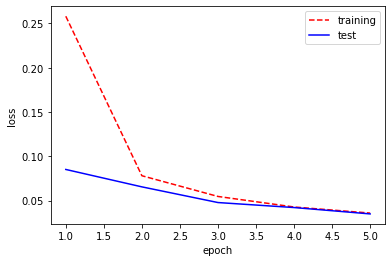

In [26]:
# on recupère la loss de training et de validation et le nombre d'epoch
training_loss=history.history["loss"]
test_loss=history.history["val_loss"]
epoch_count=range(1,len(training_loss)+1)

# visualisation de la loss
plt.plot(epoch_count[:15],training_loss[:15],"r--")
plt.plot(epoch_count[:15],test_loss[:15],"b-")
plt.legend(["Training","Test"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

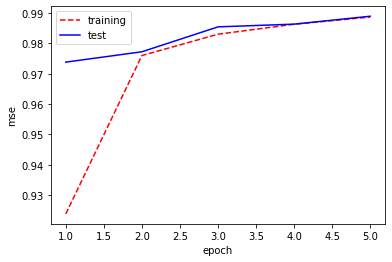

In [27]:
training_acc=history.history["accuracy"]
test_acc=history.history["val_accuracy"]

# visualisation de l'accuracy
plt.plot(epoch_count[:15],training_acc[:15],"r--")
plt.plot(epoch_count[:15],test_acc[:15],"b-")
plt.legend(["Training","Test"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

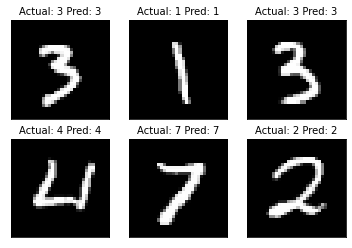

In [33]:
'''
 Si nous voulons tracer un échantillon des derniers résultats du lot, 
 voici le code pour tracer un échantillon composé de six des derniers résultats
'''

# Plot some samples and their predictions
actuals = y_test[30:36]
preds = model.predict(x_test[30:36])
predictions = np.argmax(preds,axis=1)
images = np.squeeze(x_test[30:36])
Nrows = 2

Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [32,32]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + 
str(predictions[i]),
                               fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

## II.  Implementing an advanced CNN <a class="anchor" id="Partie2"></a>

Il est crucial de pouvoir étendre les modèles CNN pour la reconnaissance d'images afin de comprendre comment augmenter la profondeur du réseau. De cette façon, nous pouvons augmenter la précision de nos prédictions si nous disposons de suffisamment de données. L'extension de la profondeur des réseaux CNN se fait de manière standard : nous répétons simplement la convolution, le max pooling et le ReLU en série jusqu'à ce que nous soyons satisfaits de la profondeur. La plupart des réseaux de reconnaissance d'images les plus précis fonctionnent de cette manière.

Dans cette recette, nous allons mettre en œuvre une méthode plus avancée de lecture des données d'image et utiliser un CNN plus grand pour faire de la reconnaissance d'image sur le jeu de données CIFAR-10. Les étiquettes potentielles pour les images sont : avion, automobile, oiseau, chat, cerf, chien, grenouille, cheval, bateau et camion.

Après avoir téléchargé les données CIFAR-10, nous avons établi un pipeline d'images. Nous avons utilisé ce pipeline d'entraînement et de test pour essayer de prédire la catégorie correcte des images. À la fin, le modèle a atteint une précision d'environ 80 % sur l'ensemble de test. Nous pouvons obtenir une meilleure précision en utilisant plus de données, en ajustant les optimiseurs ou en ajoutant plus d'époques.

Après avoir téléchargé les données CIFAR-10, nous avons établi un pipeline d'images pour convertir les images dans le format Inception requis. Nous avons ajouté un classificateur au modèle InceptionV3 et l'avons entraîné à prédire la catégorie correcte des images CIFAR-10. À la fin, le modèle a atteint une précision d'environ 63% sur l'ensemble de test. Rappelez-vous que nous affinons le modèle et réentraînons les couches entièrement connectées au sommet pour l'adapter à nos données de 10 catégories.

In [51]:
'''
Nous allons maintenant déclarer certains paramètres de l'ensemble de données 
et du modèle, puis certains paramètres de transformation de l'image, 
comme la taille que prendront les images recadrées aléatoires, puis charger le dataset.
'''

# Set dataset and model parameters
batch_size = 128
buffer_size= 128
epochs=1

# Set transformation parameters
crop_height = 24
crop_width = 24

# Loading dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a train and a test TensorFlow dataset from the NumPy arrays
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [37]:
'''
Nous définissons une fonction de lecture qui chargera et déformera légèrement 
les images pour l'entraînement avec les fonctions de modulation d'image intégrées de TensorFlow
'''

# Define CIFAR reader
def read_cifar_files(image, label):
    final_image = tf.image.resize_with_crop_or_pad(image, crop_width, crop_height)
    final_image = image / 255
    # Randomly flip the image horizontally, change the brightness and contrast
    final_image = tf.image.random_flip_left_right(final_image)
    final_image = tf.image.random_brightness(final_image,max_delta=0.1)
    final_image = tf.image.random_contrast(final_image,lower=0.5, upper=0.8)
    return final_image, label

In [39]:
dataset_train_processed = dataset_train.shuffle(buffer_size).batch(batch_size).map(read_cifar_files)
dataset_test_processed = dataset_test.batch(batch_size).map(read_cifar_files)

Ensuite, nous pouvons créer notre modèle séquentiel. Le modèle que nous allons utiliser comporte deux couches convolutionnelles suivies de trois couches entièrement connectées. Les deux couches convolutionnelles vont créer 64 caractéristiques chacune. La première couche entièrement connectée connectera la deuxième couche convolutive avec 384 nœuds cachés. La deuxième opération entièrement connectée connectera ces 384 nœuds cachés à 192 nœuds cachés. La dernière opération de couche cachée connectera ensuite les 192 nœuds aux 10 classes de sortie que nous essayons de prédire. Nous utiliserons la fonction softmax dans la dernière couche, car une image ne peut appartenir qu'à une seule catégorie, et la sortie doit donc être une distribution de probabilité sur les 10 cibles.

In [47]:
model = keras.Sequential([
    # First Conv-ReLU-Conv-ReLU-MaxPool Layer
     tf.keras.layers.Conv2D(input_shape=[32,32,3],
                            filters=32,
                            kernel_size=3,
                            padding='SAME',
                            activation="relu",
                            kernel_initializer='he_uniform',
                            name="C1"),

    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=3,
                           padding='SAME',
                           activation="relu",
                           kernel_initializer='he_uniform',
                           name="C2"),

    tf.keras.layers.MaxPool2D((2,2),
                               name="P1"),

    tf.keras.layers.Dropout(0.2),

    # Second Conv-ReLU-Conv-ReLU-MaxPool Layer
    tf.keras.layers.Conv2D(filters=64,
                            kernel_size=3,
                            padding='SAME',
                            activation="relu",
                            kernel_initializer='he_uniform',
                            name="C3"),

    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           padding='SAME',
                           activation="relu",
                           kernel_initializer='he_uniform',
                           name="C4"),

    tf.keras.layers.MaxPool2D((2,2),
                               name="P2"),
    
    tf.keras.layers.Dropout(0.2),

    # Third Conv-ReLU-Conv-ReLU-MaxPool Layer
    tf.keras.layers.Conv2D(filters=128,
                            kernel_size=3,
                            padding='SAME',
                            activation="relu",
                            kernel_initializer='he_uniform',
                            name="C5"),

    tf.keras.layers.Conv2D(filters=128,
                           kernel_size=3,
                           padding='SAME',
                           activation="relu",
                           kernel_initializer='he_uniform',
                           name="C6"),

    tf.keras.layers.MaxPool2D((2,2),
                               name="P3"),

    tf.keras.layers.Dropout(0.2),

    # Flatten Layer
    tf.keras.layers.Flatten(name="FLATTEN"),
    
    # Fully Connected Layer
    tf.keras.layers.Dense(units=128,
                           activation="relu",
                           name="D1"),

    tf.keras.layers.Dropout(0.2),

    # Final Fully Connected Layer
    tf.keras.layers.Dense(units=10,
                          activation="softmax",
                          name="OUTPUT")
    ])

In [49]:
'''
On peut maintenant compiler le modèle pour l'entraînement
'''

model.compile(loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 32, 32, 32)        896       
                                                                 
 C2 (Conv2D)                 (None, 32, 32, 32)        9248      
                                                                 
 P1 (MaxPooling2D)           (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 16, 16, 64)        18496     
                                                                 
 C4 (Conv2D)                 (None, 16, 16, 64)        36928     
                                                                 
 P2 (MaxPooling2D)           (None, 8, 8, 64)          0

In [52]:
history = model.fit(dataset_train_processed, 
                    validation_data=dataset_test_processed, 
                    epochs=epochs)

391/391 [==============================] - 233s 596ms/step - loss: 1.8667 - accuracy: 0.3206 - val_loss: 1.5254 - val_accuracy: 0.4512


## III. Retraining existing CNN models <a class="anchor" id="Partie3"></a>

L'apprentissage d'un nouveau modèle de reconnaissance d'images à partir de zéro exige beaucoup de temps et de puissance de calcul. Si nous pouvons prendre un réseau pré-entraîné et le réentraîner avec nos images, cela peut nous faire gagner du temps de calcul. Pour cette recette, nous allons montrer comment utiliser un modèle de reconnaissance d'image TensorFlow pré-entraîné et l'affiner pour qu'il fonctionne sur un ensemble différent d'images. Nous allons illustrer comment utiliser l'apprentissage par transfert à partir d'un réseau pré-entraîné pour CIFAR-10. 

L'idée est de réutiliser les poids et la structure du modèle précédent à partir des couches à convolution Cette méthode est appelée "fine tunning".

Le réseau CNN que nous allons employer utilise une architecture très populaire appelée Inception. Le modèle CNN Inception a été créé par Google et a obtenu de très bons résultats dans de nombreux tests de reconnaissance d'images.

In [54]:
batch_size = 32
buffer_size= 1000

Inception v3 est pré-entraîné sur le jeu de données ImageNet, nos images CIFAR-10 doivent donc correspondre au format de ces images. La largeur et la hauteur attendues ne doivent pas être inférieures à 75, nous allons donc redimensionner nos images à la taille spatiale 75x75. Ensuite, les images doivent être normalisées, nous appliquerons donc la tâche de prétraitement initiale (la méthode preprocess_input) sur chaque image.

In [55]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
objects = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

Maintenant, nous allons créer notre modèle basé sur le modèle InceptionV3. Nous allons charger le modèle InceptionV3 en utilisant l'API tensorflow.keras.applications. Cette API contient des modèles d'apprentissage profond pré-entraînés qui peuvent être utilisés pour la prédiction, l'extraction de caractéristiques et le réglage fin. Ensuite, nous chargerons les poids sans la tête de classification.

In [56]:
def preprocess_cifar10(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (75, 75)) 
    return tf.keras.applications.inception_v3.preprocess_input(img) , label

dataset_train_processed = dataset_train.shuffle(buffer_size).batch(batch_size).map(preprocess_cifar10)
dataset_test_processed = dataset_test.batch(batch_size).map(preprocess_cifar10)

In [66]:
inception_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(75,75,3)
)

In [68]:
'''
Nous construisons notre propre modèle sur le modèle InceptionV3 en 
ajoutant un classificateur avec trois couches entièrement connectées.
'''

x = inception_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
output = keras.layers.Dense(10, activation="softmax")(x)
model=keras.Model(inputs=inception_model.input, outputs = output)

In [69]:
for inception_layer in inception_model.layers:    
    inception_layer.trainable= False

In [70]:
model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_94[0]

In [71]:
model.fit(x=dataset_train_processed , 
          validation_data=dataset_test_processed)

1563/1563 [==============================] - 460s 290ms/step - loss: 1.1349 - accuracy: 0.6012 - val_loss: 1.0475 - val_accuracy: 0.6289
